In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import sys
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt

# Importing keras from tensorflow
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM, GRU, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay


import LSTM as lstm_impl
import CNN_LSTM as cnn_lstm_impl
import utils as model_utils
import transformer as tr_impl

In [2]:
ticker_symbol = 'GC=F'
start_date = '1995-01-01'
end_date = '2023-11-01'
raw_data = yf.download(ticker_symbol, start_date, end_date, interval='1d')
raw_data.index = raw_data.index.tz_localize(None)

features_df = pd.read_csv('../features/test_features.csv', index_col=0)

with open('../label_algorithms/labels_dict.pkl', 'rb') as file:
    labels_dict = pickle.load(file)

# Ensure indices are in the same format
raw_data.index = pd.to_datetime(raw_data.index)
features_df.index = pd.to_datetime(features_df.index)
labels_dict = {k: pd.Series(v, index=pd.to_datetime(v.index)) for k, v in labels_dict.items()}

# Find the common indices
common_indices = raw_data.index.intersection(features_df.index)
for label_series in labels_dict.values():
    common_indices = common_indices.intersection(label_series.index)

# Reindex raw_data, features_df, and each Series in labels_dict
raw_data = raw_data.reindex(common_indices)
features_df = features_df.reindex(common_indices)
labels_dict = {key: series.reindex(common_indices) for key, series in labels_dict.items()}

[*********************100%%**********************]  1 of 1 completed


In [3]:
print('Raw data shape:', raw_data.shape)
print('Features shape:', features_df.shape)
print('Labels shape:', labels_dict['ct_two_state'].shape)

Raw data shape: (3612, 6)
Features shape: (3612, 33)
Labels shape: (3612,)


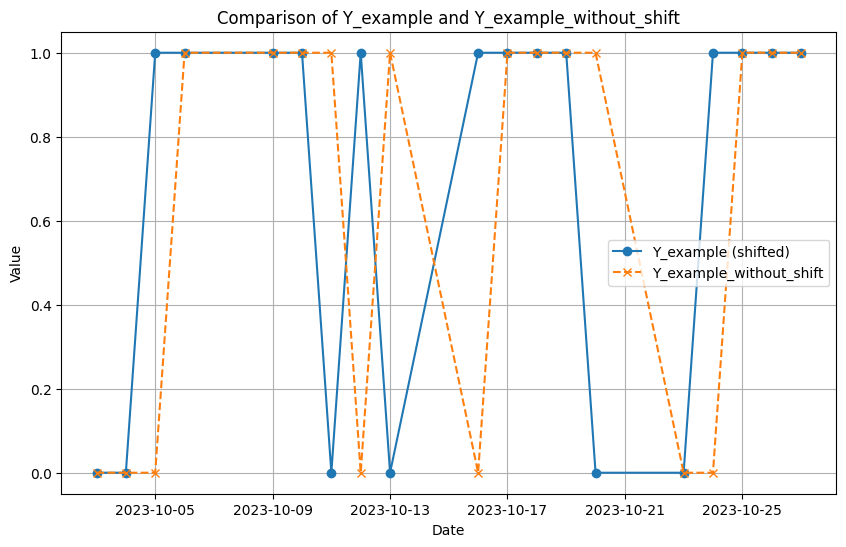

In [4]:
labels_example = labels_dict['ct_two_state'][-20:]
Y_example = labels_example.shift(-1)[:-1].astype(int)
Y_example_without_shift = labels_example[:-1].astype(int)

# Plotting the series
plt.figure(figsize=(10, 6))
plt.plot(Y_example, label='Y_example (shifted)', marker='o')
plt.plot(Y_example_without_shift, label='Y_example_without_shift', marker='x', linestyle='--')
plt.title('Comparison of Y_example and Y_example_without_shift')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
def get_X(data, window_size):
    # Normalize features to range between -1 and 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data.values)

    # Create the 3D input data shape [samples, time_steps, features] and retain dates
    X = []
    dates = []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i-window_size:i, :])
        dates.append(data.index[i-1])

    X = np.array(X)
    dates_df = pd.DataFrame(index=dates)

    return X, dates_df

def get_Y(labels: pd.Series, window_size):
    shifted_labels = labels.shift(-1)
    return shifted_labels[window_size-1:-1]

window_size = 60
example_X, dates_df = get_X(raw_data, window_size)
example_Y = get_Y(labels_dict['ct_two_state'], window_size)


print('example_X - start end dates:', dates_df.index[0], dates_df.index[-1])
print('example_Y - start end dates:', example_Y.index[0], example_Y.index[-1])

example_X - start end dates: 2009-09-15 00:00:00 2023-10-27 00:00:00
example_Y - start end dates: 2009-09-15 00:00:00 2023-10-27 00:00:00


In [7]:
window_size = 60
raw_X = model_utils.get_X(raw_data, window_size)
raw_Y_dict = {key: model_utils.get_Y(series, window_size) for key, series in labels_dict.items()}
feat_X = model_utils.get_X(features_df, 1)[window_size-1:]
feat_Y_dict = {key: model_utils.get_Y(series, 1)[window_size-1:] for key, series in labels_dict.items()}

raw_X_train, raw_X_val, feat_X_train, feat_X_val = train_test_split(raw_X, feat_X, test_size=0.2, shuffle=False)
raw_Y_train_dict, raw_Y_val_dict, feat_Y_train_dict, feat_Y_val_dict = {}, {}, {}, {}
for key in raw_Y_dict.keys():
    raw_Y_train_dict[key], raw_Y_val_dict[key], feat_Y_train_dict[key], feat_Y_val_dict[key] = train_test_split(raw_Y_dict[key], feat_Y_dict[key], test_size=0.2, shuffle=False)

raw_X_val, raw_X_test, feat_X_val, feat_X_test = train_test_split(raw_X_val, feat_X_val, test_size=0.25, shuffle=False)
raw_Y_test_dict, feat_Y_test_dict = {}, {}
for key in raw_Y_val_dict.keys():
    raw_Y_val_dict[key], raw_Y_test_dict[key], feat_Y_val_dict[key], feat_Y_test_dict[key] = train_test_split(raw_Y_val_dict[key], feat_Y_val_dict[key], test_size=0.25, shuffle=False)

print('Raw X train shape:', raw_X_train.shape)
print('Raw X val shape:', raw_X_val.shape)
print('Raw X test shape:', raw_X_test.shape)
print('Raw Y train shape:', raw_Y_train_dict['ct_two_state'].shape)
print('Raw Y val shape:', raw_Y_val_dict['ct_two_state'].shape)
print('Raw Y test shape:', raw_Y_test_dict['ct_two_state'].shape)
print()
print('Features X train shape:', feat_X_train.shape)
print('Features X val shape:', feat_X_val.shape)
print('Features X test shape:', feat_X_test.shape)
print('Features Y train shape:', feat_Y_train_dict['ct_two_state'].shape)
print('Features Y val shape:', feat_Y_val_dict['ct_two_state'].shape)
print('Features Y test shape:', feat_Y_test_dict['ct_two_state'].shape)

Raw X train shape: (2841, 60, 6)
Raw X val shape: (533, 60, 6)
Raw X test shape: (178, 60, 6)
Raw Y train shape: (2841, 1)
Raw Y val shape: (533, 1)
Raw Y test shape: (178, 1)

Features X train shape: (2841, 1, 33)
Features X val shape: (533, 1, 33)
Features X test shape: (178, 1, 33)
Features Y train shape: (2841, 1)
Features Y val shape: (533, 1)
Features Y test shape: (178, 1)


## LSTM

In [8]:
# Create a learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

# Create an Adam optimizer with the learning rate schedule
opt = Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    amsgrad=False)

# Build the LSTM model
lstm_model = lstm_impl.model(X.shape[1], X.shape[2])

# Compile the model
lstm_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

lstm_model.fit(X_train,Y_train,epochs=2,batch_size=batch_size,verbose=1)

lstm_model.save('./saved_models/lstm_model.keras')

Epoch 1/2
11/11 [==============================] - 7s 274ms/step - loss: 0.6551 - accuracy: 0.6424
Epoch 2/2
11/11 [==============================] - 3s 251ms/step - loss: 0.6370 - accuracy: 0.6688


In [9]:
loaded_model = load_model('./saved_models/lstm_model.keras')
loaded_model.evaluate(X_test,Y_test)

37/37 [==============================] - 2s 19ms/step - loss: 0.6424 - accuracy: 0.6589


[0.6423724293708801, 0.6588744521141052]

## CNN-LSTM

In [16]:
# Create a learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

# Create an Adam optimizer with the learning rate schedule
opt = Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    amsgrad=False)

n_steps = 4
n_length = 10
n_fetures = X_train.shape[2]
X_train_r = X_train.reshape((X_train.shape[0], n_steps, n_length, n_fetures))
X_test_r = X_test.reshape((X_test.shape[0], n_steps, n_length, n_fetures))
print(X_train_r.shape, X_test_r.shape)

# Build the CNN-LSTM model
cnn_lstm_model = cnn_lstm_impl.model(n_length, n_fetures)

# Compile the model
cnn_lstm_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

cnn_lstm_model.fit(X_train_r,Y_train,epochs=1000,batch_size=batch_size,verbose=1)

(5280, 4, 10, 6) (1321, 4, 10, 6)
Epoch 1/1000
10/10 [==============================] - 3s 46ms/step - loss: 0.6962 - accuracy: 0.5267
Epoch 2/1000
10/10 [==============================] - 0s 46ms/step - loss: 0.6874 - accuracy: 0.5521
Epoch 3/1000
10/10 [==============================] - 0s 46ms/step - loss: 0.6869 - accuracy: 0.5521
Epoch 4/1000
10/10 [==============================] - 0s 46ms/step - loss: 0.6860 - accuracy: 0.5521
Epoch 5/1000
10/10 [==============================] - 0s 49ms/step - loss: 0.6831 - accuracy: 0.5521
Epoch 6/1000
10/10 [==============================] - 0s 46ms/step - loss: 0.6806 - accuracy: 0.5521
Epoch 7/1000
10/10 [==============================] - 0s 46ms/step - loss: 0.6807 - accuracy: 0.5754
Epoch 8/1000
10/10 [==============================] - 0s 49ms/step - loss: 0.6779 - accuracy: 0.5794
Epoch 9/1000
10/10 [==============================] - 0s 45ms/step - loss: 0.6809 - accuracy: 0.5871
Epoch 10/1000
10/10 [==============================] - 0s

In [17]:
cnn_lstm_model.evaluate(X_test_r,Y_test)

42/42 [==============================] - 1s 4ms/step - loss: 0.7123 - accuracy: 0.5223


[0.7123053073883057, 0.5223315954208374]

## Transformer

In [16]:
input_shape = X_train.shape[1:]

tr_model = tr_impl.build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

tr_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy'],
)
tr_model.summary()

tr_model.fit(
    X_train,
    Y_train,
    epochs=50,
    batch_size=batch_size,
)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 40, 6)]              0         []                            
                                                                                                  
 layer_normalization_24 (La  (None, 40, 6)                12        ['input_4[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_12 (M  (None, 40, 6)                27654     ['layer_normalization_24[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalization_24

In [14]:
tr_model.evaluate(X_test, Y_test, verbose=1)

42/42 [==============================] - 4s 94ms/step - loss: 0.7153 - accuracy: 0.5223


[0.7153221964836121, 0.5223315954208374]